In [1]:
from shapely.ops import unary_union, linemerge
from sklearn.cluster import DBSCAN
from shapely.geometry import LineString, GeometryCollection, Point, MultiLineString
import numpy as np
from itertools import combinations
from scipy.spatial import cKDTree

In [2]:
# Normaliser chaque segment en triant les points pour garantir [AB] = [BA]
def normalize_segment(segment):
    """Trie les points du segment pour garantir l'unicité et éviter les doublons"""
    if not isinstance(segment, LineString):
        return segment
    coords = list(segment.coords)
    return LineString(sorted(coords))  # Trie les points par ordre croissant

In [3]:
# Fonction utilitaire pour convertir les géométries en liste de LineStrings
def ensure_line_list(segments):
    """Convertit différents types de collections de géométries en liste de LineString"""
    if isinstance(segments, GeometryCollection) or isinstance(segments, MultiLineString):
        segments = list(segments.geoms)
    elif not isinstance(segments, list):
        segments = [segments]
    return [s for s in segments if isinstance(s, LineString)]

In [4]:
# Fonction de snapping améliorée avec KDTree pour plus d'efficacité
def snap_segments(segments, tol=0.05):
    """Aligne les extrémités proches à une même coordonnée avec une approche optimisée"""
    segments = ensure_line_list(segments)
    if not segments:
        return []
    
    # Extraire tous les points (extrémités) des segments
    endpoints = []
    endpoint_to_segments = {}
    
    for i, seg in enumerate(segments):
        if len(seg.coords) < 2:
            continue
            
        start, end = tuple(seg.coords[0]), tuple(seg.coords[-1])
        
        # Associer chaque point aux segments qui l'utilisent
        for pt in (start, end):
            if pt not in endpoint_to_segments:
                endpoint_to_segments[pt] = []
                endpoints.append(pt)
            endpoint_to_segments[pt].append((i, pt == start))  # Stocker l'index et si c'est le début
    
    if not endpoints:
        return segments

    # Utiliser KDTree pour une recherche efficace des points proches
    tree = cKDTree(endpoints)
    
    # Identifier les groupes de points qui devraient être snappés ensemble
    snapped_groups = []
    processed = set()
    
    for i, pt in enumerate(endpoints):
        if i in processed:
            continue
            
        # Trouver tous les points dans le rayon de tolérance
        indices = tree.query_ball_point(pt, tol)
        if indices:
            group = [endpoints[j] for j in indices]
            for j in indices:
                processed.add(j)
            snapped_groups.append(group)
    
    # Créer un mapping pour chaque point vers sa position snappée
    snap_map = {}
    for group in snapped_groups:
        # Choisir la position moyenne comme nouvelle position
        avg_position = tuple(np.mean(group, axis=0))
        for pt in group:
            snap_map[pt] = avg_position
    
    # Pour les points qui n'ont pas été snappés, les conserver tels quels
    for i, pt in enumerate(endpoints):
        if pt not in snap_map:
            snap_map[pt] = pt
    
    # Reconstruire les segments avec les points snappés
    new_segments = []
    for i, seg in enumerate(segments):
        coords = list(seg.coords)
        
        # Snapper uniquement les extrémités
        new_coords = list(coords)
        if len(coords) >= 2:
            new_coords[0] = snap_map.get(tuple(coords[0]), coords[0])
            new_coords[-1] = snap_map.get(tuple(coords[-1]), coords[-1])
        
        # Vérifier que le segment a toujours une longueur non nulle après snapping
        if len(new_coords) >= 2 and new_coords[0] != new_coords[-1]:
            new_segments.append(LineString(new_coords))
    
    return new_segments

In [5]:
def remove_isolated_segments(segments, tolerance=1e-6):
    """Supprime les segments qui ne touchent aucun autre segment"""
    segments = ensure_line_list(segments)
    
    # Amélioration: créer un buffer autour des extrémités pour gérer les imprécisions numériques
    endpoints = []
    for seg in segments:
        p1, p2 = Point(seg.coords[0]), Point(seg.coords[-1])
        endpoints.append((seg, p1.buffer(tolerance), p2.buffer(tolerance)))
    
    keep_segments = []
    for i, (seg1, p1_buf, p2_buf) in enumerate(endpoints):
        connected = False
        for j, (seg2, q1_buf, q2_buf) in enumerate(endpoints):
            if i == j:
                continue
            # Vérifier si les extrémités se touchent
            if p1_buf.intersects(q1_buf) or p1_buf.intersects(q2_buf) or \
               p2_buf.intersects(q1_buf) or p2_buf.intersects(q2_buf):
                connected = True
                break
        if connected:
            keep_segments.append(seg1)
    
    return keep_segments

In [6]:
def are_collinear(seg1, seg2, angle_tol=0.1, distance_tol=0.3):
    """Vérifie si deux segments sont colinéaires (même orientation + alignement sur la même droite) et donc en realité c'est la même ligne """
    if not isinstance(seg1, LineString) or not isinstance(seg2, LineString):
        return False
        
    coords1, coords2 = list(seg1.coords), list(seg2.coords)
    
    if len(coords1) < 2 or len(coords2) < 2:
        return False

    # Calcul de l'orientation (angle du segment)
    orientation1 = np.arctan2(coords1[1][1] - coords1[0][1], coords1[1][0] - coords1[0][0])
    orientation2 = np.arctan2(coords2[1][1] - coords2[0][1], coords2[1][0] - coords2[0][0])

    # Normalisation des angles entre -pi et pi
    angle_diff = abs(orientation1 - orientation2)
    angle_diff = min(angle_diff, np.pi - angle_diff if angle_diff > np.pi/2 else angle_diff)
    
    # Vérifier que l'angle est similaire (considérer aussi les angles opposés)
    if angle_diff > angle_tol and abs(angle_diff - np.pi) > angle_tol:
        return False

    # Vérifier que les segments sont alignés sur la même droite
    # Un segment est sur la droite d'un autre si les déterminants sont nuls
    x1, y1 = coords1[0]
    x2, y2 = coords1[1]
    x3, y3 = coords2[0]
    x4, y4 = coords2[1]

    # Utiliser la distance point-droite au lieu du déterminant pour plus de précision
    if abs(x2 - x1) > abs(y2 - y1):  # Ligne plus horizontale
        slope = (y2 - y1) / (x2 - x1) if x2 != x1 else float('inf')
        intercept = y1 - slope * x1
        dist1 = abs(y3 - (slope * x3 + intercept)) / np.sqrt(1 + slope**2)
        dist2 = abs(y4 - (slope * x4 + intercept)) / np.sqrt(1 + slope**2)
    else:  # Ligne plus verticale
        slope = (x2 - x1) / (y2 - y1) if y2 != y1 else float('inf')
        intercept = x1 - slope * y1
        dist1 = abs(x3 - (slope * y3 + intercept)) / np.sqrt(1 + slope**2)
        dist2 = abs(x4 - (slope * y4 + intercept)) / np.sqrt(1 + slope**2)

    return dist1 < distance_tol and dist2 < distance_tol

In [7]:
def merge_segments(segments):
    """Fusionne les segments colinéaires adjacents avec une approche plus robuste"""
    segments = ensure_line_list(segments)
    segments = [normalize_segment(s) for s in segments]
    
    # Utiliser linemerge de Shapely pour une fusion plus robuste
    while True:
        old_count = len(segments)
        
        # Regrouper les segments colinéaires qui se touchent
        merged = []
        processed = set()
        
        for i, seg1 in enumerate(segments):
            if i in processed:
                continue
                
            current_group = [seg1]
            processed.add(i)
            
            # Chercher récursivement tous les segments connectés et colinéaires
            to_check = [i]
            while to_check:
                current_idx = to_check.pop(0)
                current_seg = segments[current_idx]
                
                for j, seg2 in enumerate(segments):
                    if j in processed:
                        continue
                        
                    if current_seg.touches(seg2) and are_collinear(current_seg, seg2):
                        current_group.append(seg2)
                        processed.add(j)
                        to_check.append(j)
            
            # Fusionner le groupe
            if len(current_group) > 1:
                try:
                    result = linemerge(current_group)
                    if isinstance(result, MultiLineString):
                        merged.extend(list(result.geoms))
                    else:
                        merged.append(result)
                except Exception:
                    # Fallback à unary_union en cas d'échec
                    result = unary_union(current_group)
                    if isinstance(result, MultiLineString):
                        merged.extend(list(result.geoms))
                    elif isinstance(result, LineString):
                        merged.append(result)
                    else:
                        merged.extend(current_group)
            else:
                merged.append(current_group[0])
        
        segments = merged
        
        # Si aucun segment n'a été fusionné dans cette itération, on s'arrête
        if len(segments) >= old_count:
            break
    
    return segments

In [55]:
def cluster_parallel_segments(segments, angle_tol=0.1, distance_tol=0.3):
    """Regroupe les segments colinéaires proches en vérifiant leur alignement exact"""
    segments = ensure_line_list(segments)

    # Si peu de segments, traitement direct sans clustering
    if len(segments) <= 1:
        return segments

    # Créer une matrice de similarité entre segments
    n = len(segments)
    adjacency_matrix = np.zeros((n, n))

    # Optimisation: utiliser combinations pour éviter la redondance
    for i, j in combinations(range(n), 2):
        if are_collinear(segments[i], segments[j], angle_tol, distance_tol):
            adjacency_matrix[i, j] = 1
            adjacency_matrix[j, i] = 1

    # Appliquer DBSCAN avec une nouvelle distance basée sur la matrice de similarité
    # Paramètres ajustés pour être plus robustes
    clustering = DBSCAN(metric="precomputed", eps=0.5, min_samples=1).fit(1 - adjacency_matrix)

    # Regrouper les segments par cluster
    clustered_segments = {}
    for i, label in enumerate(clustering.labels_):
        if label not in clustered_segments:
            clustered_segments[label] = []
        clustered_segments[label].append(segments[i])

    # Fusionner chaque cluster
    merged_segments = []
    for label, segs in clustered_segments.items():
        # Essayer d'abord linemerge qui est plus adapté aux lignes
        try:
            result = linemerge(segs)
            if isinstance(result, MultiLineString):
                merged_segments.extend(list(result.geoms))
            else:
                merged_segments.append(result)
        except Exception:
            # Fallback à unary_union
            result = unary_union(segs)
            if isinstance(result, MultiLineString):
                merged_segments.extend(list(result.geoms))
            elif isinstance(result, LineString):
                merged_segments.append(result)
            else:
                # Dernière chance: garder les segments d'origine
                merged_segments.extend(segs)
    
    return merged_segments

In [58]:
def complete_preprocessing(segments, angle_tol=0.1, distance_tol=0.3, snap_tol=0.05):
    """Applique l'ensemble du prétraitement en une seule fonction"""
    # 1. Assurer que les segments sont des LineString
    segments = ensure_line_list(segments)
    
    # 2. Appliquer le snapping pour aligner les extrémités proches
    segments = snap_segments(segments, tol=snap_tol)
    
    # 3. Fusionner les segments colinéaires adjacents
    segments = merge_segments(segments)
    
    # 4. Éliminer les segments isolés
    segments = remove_isolated_segments(segments)
    
    # 5. Regrouper les segments parallèles
    #segments = cluster_parallel_segments(segments, angle_tol, distance_tol)
    
    return segments

In [9]:
from pathlib import Path
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from floor_plan_class import FloorPlan

import utils.segment_geometry as sg
import utils.parse_geojson as pg



Nombre de segments avant prétraitement: 22425


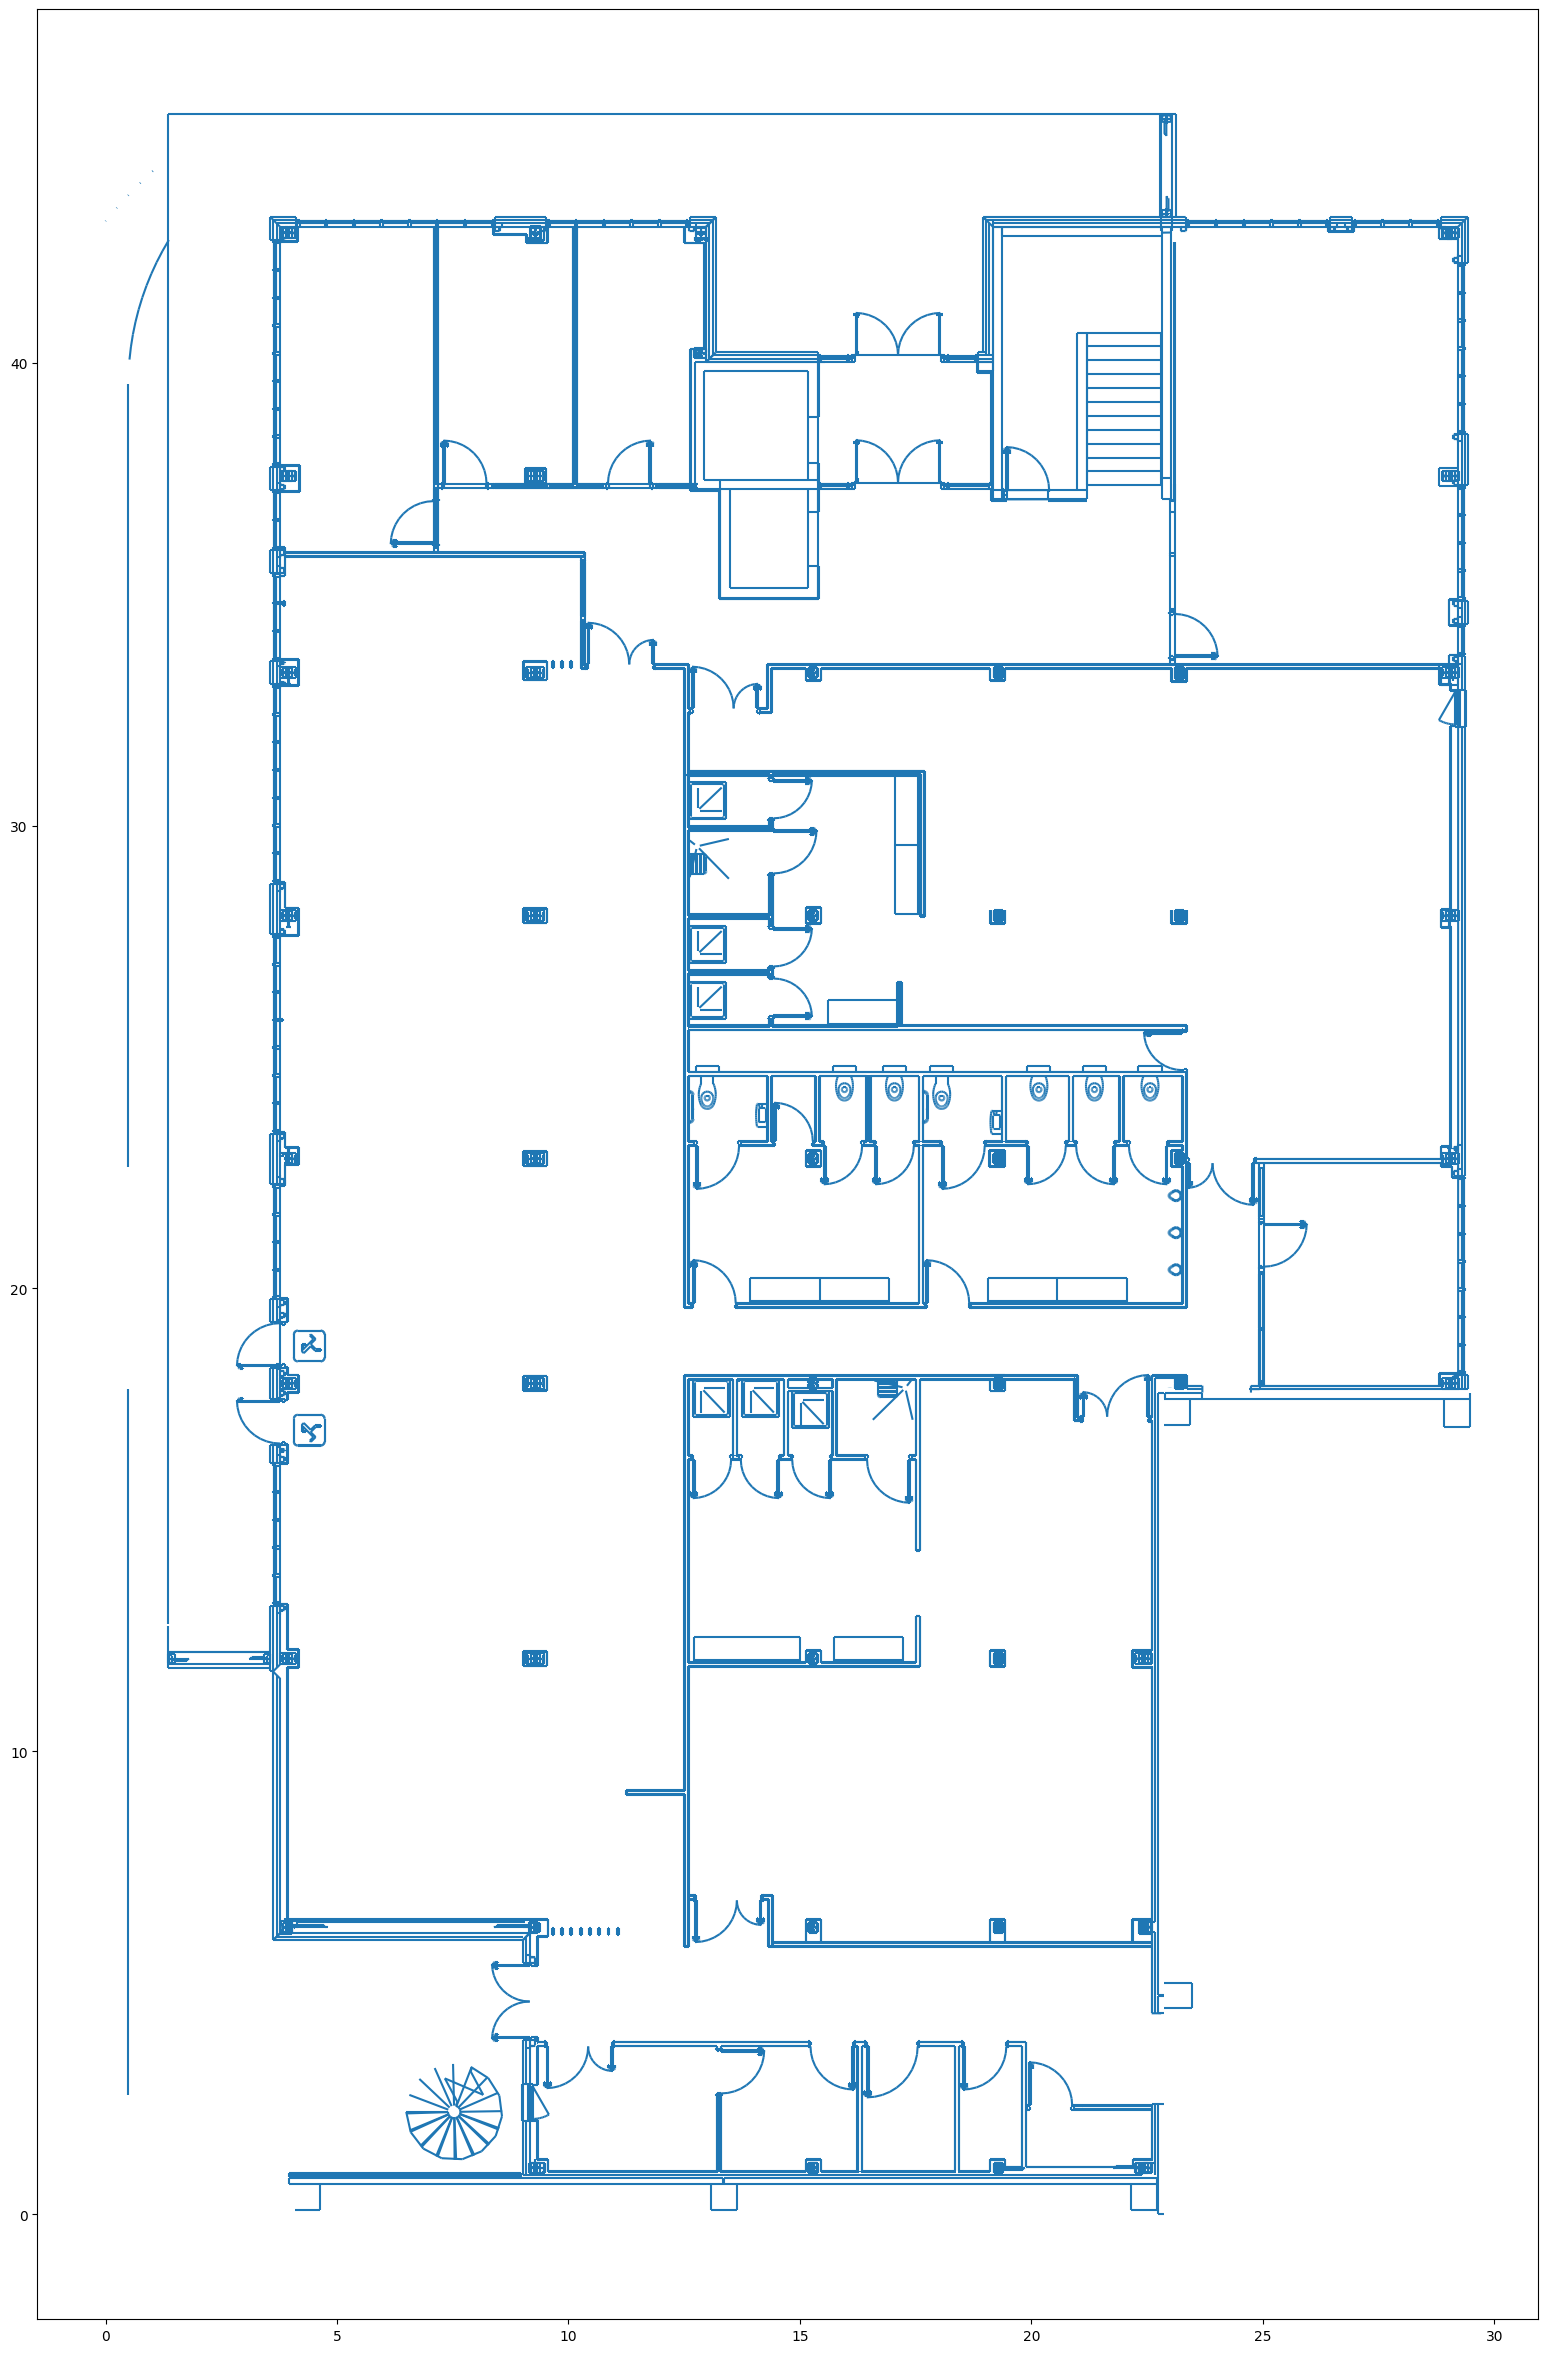

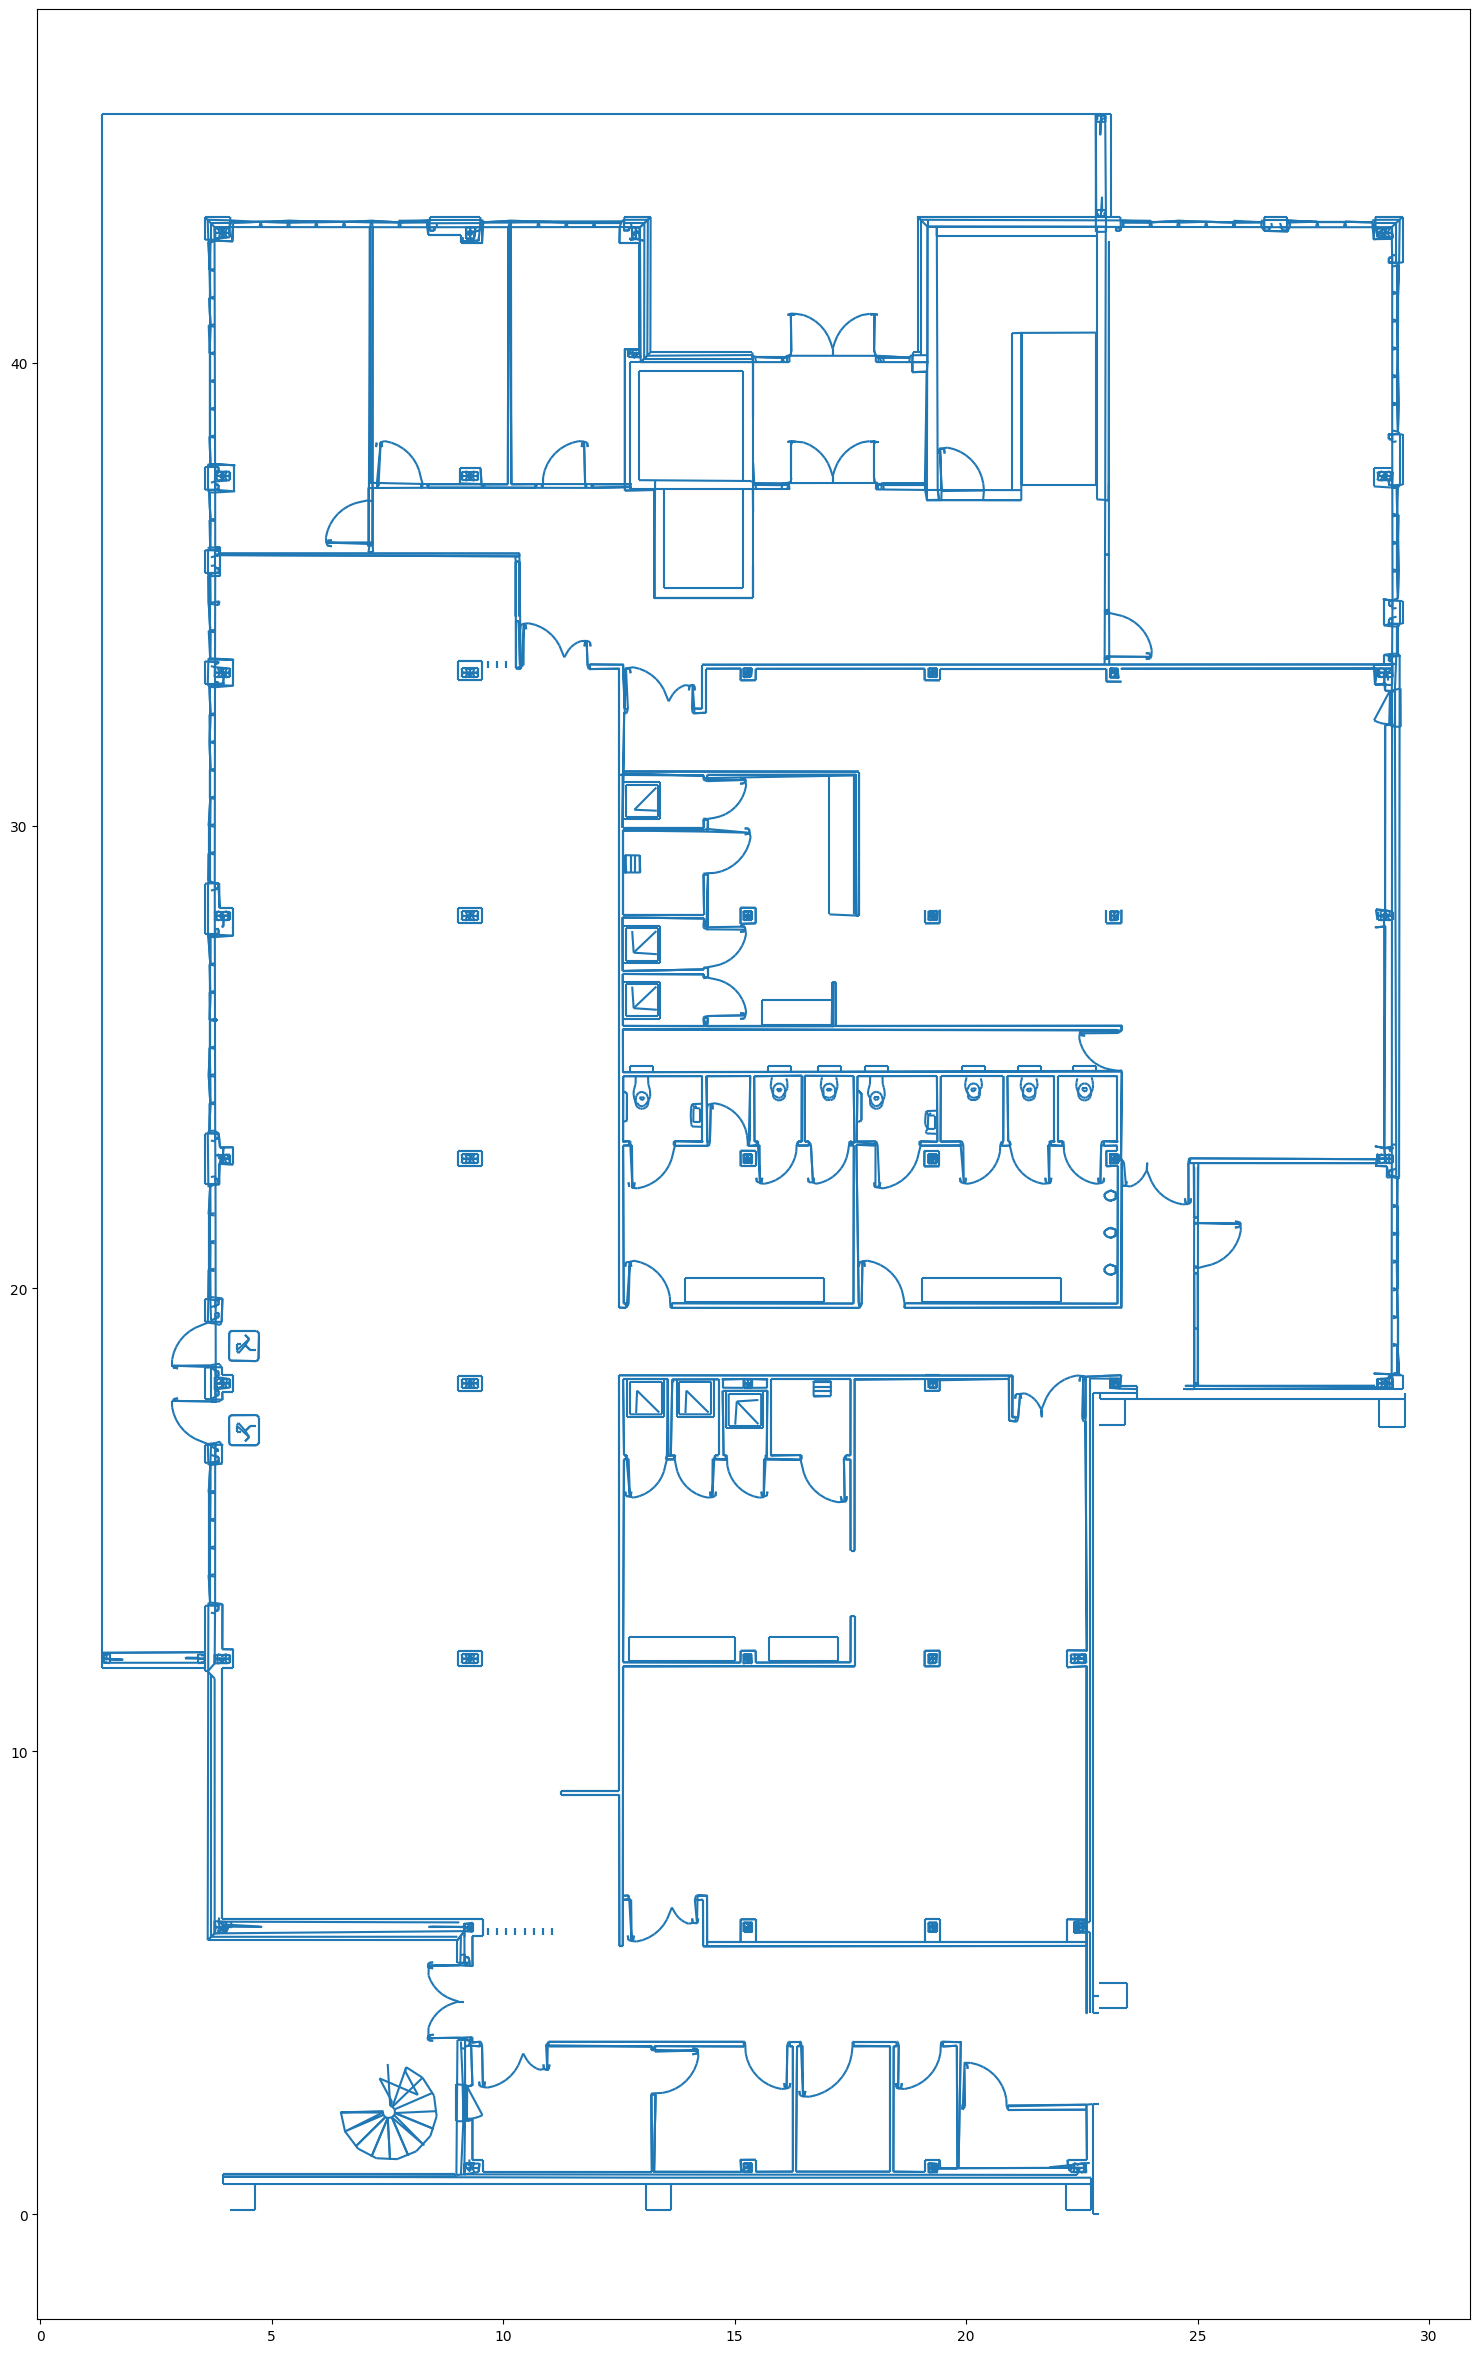

Nombre de segments après prétraitement: 6417


In [77]:
# Définition du répertoire de travail et du fichier
data_dir = Path("data", "clean")
filename = "Output2_clean.geojson"

# Charger les segments du plan
segments, transform_parameters = pg.load_segments(data_dir / filename)
n_segments = len(segments.geoms)
print('Nombre de segments avant prétraitement:', n_segments)

# Affichage du plan AVANT le prétraitement
pg.plot_GeometryCollection(segments)

# Appliquer le prétraitement 
cleaned_segments = complete_preprocessing(segments)

# Affichage du plan APRÈS le prétraitement

pg.plot_GeometryCollection(MultiLineString(cleaned_segments))


# Nombre de segments après nettoyage
print('Nombre de segments après prétraitement:', len(cleaned_segments))

In [78]:
from shapely.geometry import mapping
import json

output_filename = "preprocessed_2.geojson"

# Convertir les segments en GeoJSON
geojson_data = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "geometry": mapping(line),
            "properties": {}
        }
        for line in cleaned_segments
    ]
}

# 📂 Enregistrer dans un fichier GeoJSON
output_path = data_dir / output_filename
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(geojson_data, f, indent=4)

print(f" Fichier enregistré : {output_path}")

 Fichier enregistré : data/clean/preprocessed_2.geojson


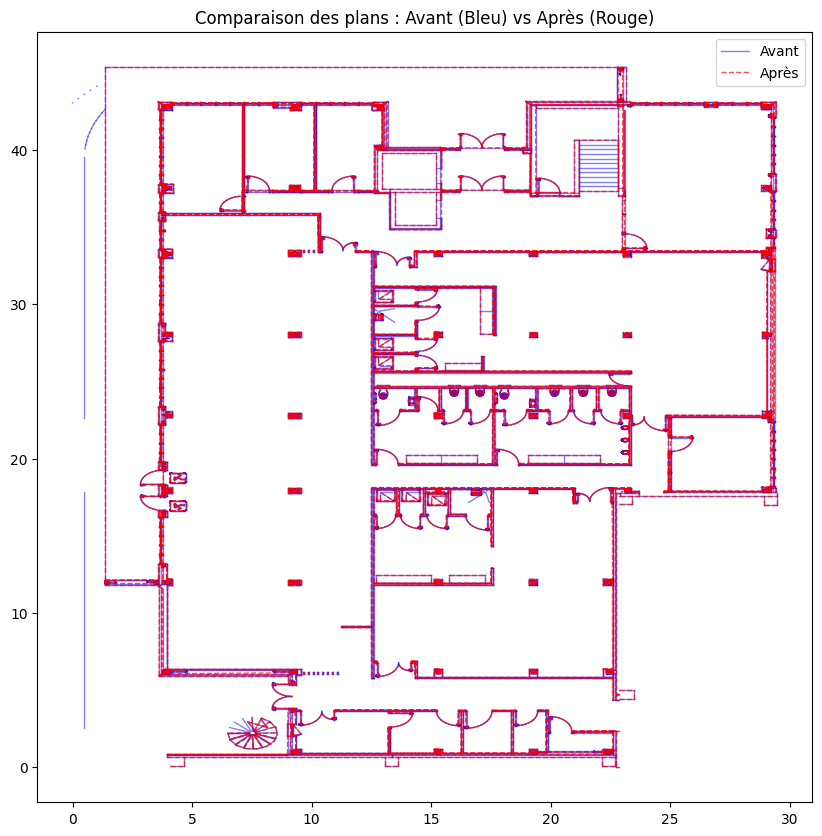

In [80]:
import matplotlib.pyplot as plt

# Créer une figure
fig, ax = plt.subplots(figsize=(10, 10))

#  Tracer le plan AVANT en BLEU
for line in segments.geoms:  # Si `segments` est une `GeometryCollection`
    x, y = line.xy
    ax.plot(x, y, color="blue", linestyle="-", linewidth=1, alpha=0.5, label="Avant" if "Avant" not in ax.get_legend_handles_labels()[1] else "")

#  Tracer le plan APRÈS en ROUGE
for line in cleaned_segments:  # Si `cleaned_segments` est une liste de `LineString`
    x, y = line.xy
    ax.plot(x, y, color="red", linestyle="--", linewidth=1, alpha=0.7, label="Après" if "Après" not in ax.get_legend_handles_labels()[1] else "")

#  Ajouter une légende et un titre
ax.legend()
ax.set_title("Comparaison des plans : Avant (Bleu) vs Après (Rouge)")

#  Afficher le graphique
plt.show()


In [81]:
from scipy.spatial import cKDTree
import numpy as np

# Extraire les coordonnées des centres des segments avant/après
def get_segment_centroids(segments):
    return np.array([[(line.centroid.x, line.centroid.y)] for line in segments.geoms])

original_centroids = get_segment_centroids(segments)
processed_centroids = get_segment_centroids(MultiLineString(cleaned_segments))

# Construire un KDTree sur le plan traité
tree = cKDTree(processed_centroids.reshape(-1, 2))

# Trouver la distance minimale pour chaque segment original
distances, _ = tree.query(original_centroids.reshape(-1, 2))

# Calculer la distance moyenne
mean_distance = np.mean(distances)
print(f"Distance moyenne entre les segments avant/après : {mean_distance:.6f}")


Distance moyenne entre les segments avant/après : 0.028213


In [83]:
print(f"Nombre de segments avant prétraitement : {len(segments.geoms)}")
print(f"Nombre de segments après prétraitement : {len(cleaned_segments)}")

# Vérification du pourcentage de segments supprimés
deleted_percentage = (len(segments.geoms) - len(cleaned_segments)) / len(segments.geoms) * 100
print(f"Pourcentage de segments supprimés : {deleted_percentage:.2f}%")


Nombre de segments avant prétraitement : 22425
Nombre de segments après prétraitement : 6417
Pourcentage de segments supprimés : 71.38%


Conclusion des résultats :
 
output1: 
Nombre de segments avant prétraitement : 1952
Nombre de segments après prétraitement : 1650
Pourcentage de segments supprimés : 15.47%
Distance moyenne entre les segments avant/après : 0.063185

output2:
Nombre de segments avant prétraitement: 22425
Nombre de segments après prétraitement: 6417
Pourcentage de segments supprimés : 72.59%71.38%
0.02

output3: 
Nombre de segments avant prétraitement: 520
Nombre de segments après prétraitement: 330
 Distance moyenne entre les segments avant/après: 0.443069 : problème

output4:
Nombre de segments avant prétraitement: 964
Nombre de segments après prétraitement: 582
0.182077
39.63%

output5:
Nombre de segments avant prétraitement: 505
Nombre de segments après prétraitement: 491
0.103424
Pourcentage de segments supprimés : 2.77%

output6:
Nombre de segments avant prétraitement : 4909
Nombre de segments après prétraitement : 3011
Pourcentage de segments supprimés : 38.66%
Distance moyenne entre les segments avant/après : 0.073806


output7: 
Nombre de segments avant prétraitement: 6013
Nombre de segments après prétraitement: 1648
Distance moyenne entre les segments avant/après : 0.025068
Pourcentage de segments supprimés : 72.59%

output8:
Nombre de segments avant prétraitement : 50874
Nombre de segments après prétraitement : 14266
Distance moyenne entre les segments avant/après : 0.036570
Pourcentage de segments supprimés : 71.96%
24min : problème


Remarque: 
-Le prétraitement peut prendre quelques minutes si on a un nombre important de segment dans le fichier de départ. 
-Algo efficace si le nombre de segment est elevés (on peut diminuer le nombre de segments de 70% tout en gardant presque le même visuel et donc le même plan).
-Moins efficace avec un fichieer de départ contenant déjà un nombre limité de segment. Pour l'output 3 on a une distance moyenne entre les segments avant/après: 0.443069 ce qui veut dire qu'en moyenne, chaque segment a été bougé de 44% ce qui n'est pas le résultat attendu. 

Reste à tester avec algo de graph avec les fichier avant et apres 